# End-to-end SSL stepcounter training with OxWalk, modified with granular postures

This notebook trains the stepcounter that was used in:

Small SR, Chan S, Walmsley R, et al. (2023)
[Development and Validation of a Machine Learning Wrist-worn Step Detection Algorithm with Deployment in the UK Biobank](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).
medRxiv. DOI: 10.1101/2023.02.20.

This notebook has been modified to run on Dr. Keadle's Cal Poly ACT24 data.

Original notebook can be found [here](https://github.com/OxWearables/stepcount/blob/main/train-ssl.ipynb).

## Imports

In [1]:
import re
import glob
import os
import numpy as np
import pandas as pd
import pathlib
import torch
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

Check torch version and to see if GPU acceleration is available.

This notebook was originally run on torch version 2.2.2+cu121, with GPU acceleration.

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

2.2.2+cu121
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Data processing

Below are functions to load the data, adapted from the original functions provided by UK Biobank. Requires the following files:
- ACT24_Apr2024 directory, with ACT24_###_#_SSL.csv files created by the DATA 2024 team. ### is the id, # is the observation.

In [3]:
DATA_DIR = 'ACT24_Apr2024'  # location of data (the ACT24_###_#_SSL.csv files should be in this folder)
DATAFILES = os.path.join(DATA_DIR, 'ACT24_*.csv')
OUT_DIR = './data/act24_80hz_4/'  # output location of the processed dataset
WINDOW_SEC = 10  # seconds per epoch
STEP_THRESHOLD = 4  # how many steps per window to consider a step (equal or more). This is not used in this notebook but is kept as a placeholder

DEVICE_HZ = 80  # original sample rate Hz
RESAMPLE_HZ = 30  # Hz
WINDOW_OVERLAP_SEC = 0  # seconds
WINDOW_LEN = int(DEVICE_HZ * WINDOW_SEC)  # device ticks
WINDOW_OVERLAP_LEN = int(DEVICE_HZ * WINDOW_OVERLAP_SEC)  # device ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # device ticks
WINDOW_TOL = 0.01  # 1%


def resize(x, length, axis=1):
    """Resize the temporal length using linear interpolation.
    X must be of shape (N,M,C) (channels last) or (N,C,M) (channels first),
    where N is the batch size, M is the temporal length, and C is the number
    of channels.
    If X is channels-last, use axis=1 (default).
    If X is channels-first, use axis=2.
    """
    from scipy.interpolate import interp1d

    length_orig = x.shape[axis]
    t_orig = np.linspace(0, 1, length_orig, endpoint=True)
    t_new = np.linspace(0, 1, length, endpoint=True)
    x = interp1d(t_orig, x, kind="linear", axis=axis, assume_sorted=True)(
        t_new
    )
    return x


def is_good_quality(w):
    """ Window quality check """

    if w.isna().any().any():
        return False

    if len(w) != WINDOW_LEN:
        return False

    w_start, w_end = w.index[0], w.index[-1]
    w_duration = w_end - w_start
    target_duration = pd.Timedelta(WINDOW_SEC, 's')
    if np.abs(w_duration - target_duration) > WINDOW_TOL * target_duration:
        return False

    return True


def make(datafile):
    X, Y, T, P = [], [], [], []
    y_step = []
    Y_all = []

    data = pd.read_csv(datafile, parse_dates=['timestamp'], index_col='timestamp')

    p = re.search(r'(ACT24_\d{3}_\d{1})', datafile, flags=re.IGNORECASE).group()

    for i in range(0, len(data), WINDOW_STEP_LEN):
        w = data.iloc[i:i + WINDOW_LEN]
        postures = w['posture'].mode()

        if not is_good_quality(w) or "private/not coded" in list(postures):
            continue

        t = w.index[0].to_datetime64()
        x = w[['x', 'y', 'z']].values
        posture = postures.sample(n=1).iloc[0]
        count = int(w['step'].sum())
        
        if posture in ['lying', 'kneeling/ squatting', 'stretching', 'stand', 'sitting']:
            y = 'nomvmt'
        elif posture in ['descend stairs', 'walk with load']:
            y = 'modwalk'
        else:
            y = posture
            
        y_all = posture

        X.append(x)
        Y.append(y)
        T.append(t)
        P.append(p)
        y_step.append(count)
        Y_all.append(y_all)

    X = np.asarray(X)
    Y = np.asarray(Y)
    T = np.asarray(T)
    P = np.asarray(P)
    y_step = np.asarray(y_step)
    y_all = np.asarray(Y_all)

    if DEVICE_HZ != RESAMPLE_HZ:
        X = resize(X, int(RESAMPLE_HZ * WINDOW_SEC))

    return X, Y, T, P, y_step, y_all

Convert the raw data into 10s windowed data `X` at 30Hz, with step count annotations `Y_step` and group labels `groups`. A categorical array `Y` is also generated. Save to disk for later reuse. **This means that the code in this section only needs to be run once!**

In [4]:
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with Parallel(n_jobs=4, prefer="threads") as parallel:
    results = parallel(delayed(make)(datafile) for datafile in tqdm(glob.glob(DATAFILES)))

x, y, t, p, y_step, y_all = zip(*results)

X = np.vstack(x)  # data windows
Y = np.hstack(y)  # binary labels walk/notwalk (based on Y_step >= STEP_THRESHOLD)
Y_step = np.hstack(y_step)  # step counts per window
T = np.hstack(t)  # timestamps
groups = np.hstack(p)  # group ids
Y_all = np.hstack(y_all)

np.save(os.path.join(OUT_DIR, 'X'), X)
np.save(os.path.join(OUT_DIR, 'Y'), Y)
np.save(os.path.join(OUT_DIR, 'time'), T)
np.save(os.path.join(OUT_DIR, 'groups'), groups)
np.save(os.path.join(OUT_DIR, 'Y_step'), Y_step)
np.save(os.path.join(OUT_DIR, 'Y_all'), Y_all)

print(f"Saved in {OUT_DIR}")
print("X shape:", X.shape)
print("Y distribution:")
print(pd.Series(Y).value_counts())

100%|██████████| 32/32 [02:14<00:00,  4.21s/it]


Saved in ./data/act24_80hz_4/
X shape: (32640, 300, 3)
Y distribution:
nomvmt                  25172
walk                     3141
stand and move           2911
modwalk                   842
bike                      263
ascend stairs             171
muscle strengthening       95
other sport movement       44
running                     1
Name: count, dtype: int64


## Load data from disk

The oxwearables activity classifier can only use numeric input, so below we create mappings to convert the posture categorical labels to numbers and back.

In [3]:
posture_to_num = {"nomvmt": 0, "walk": 1, "stand and move": 2, "modwalk": 3, "bike": 4, "ascend stairs": 5, "muscle strengthening": 6, "other sport movement": 7, "running": 8}
num_to_posture = {0: "nomvmt", 1: "walk", 2: "stand and move", 3: "modwalk", 4: "bike", 5: "ascend stairs", 6: "muscle strengthening", 7: "other sport movement", 8: "running"}

Load data from disk. This is what was saved in the previous section. Note that the postures have been converted to numbers.

In [4]:
path = './data/act24_80hz_4/'

X = np.load(path + 'X.npy')
Y_step = np.load(path + 'Y_step.npy')
Y = pd.Series(np.load(path + 'Y.npy')).map(posture_to_num).to_numpy()
groups = np.load(path + 'groups.npy')
T = np.load(path + 'time.npy')

classes_all = np.unique(Y)
classes_num = len(classes_all)

In [5]:
pd.Series(Y).value_counts(normalize=True)

0    0.771201
1    0.096232
2    0.089185
3    0.025797
4    0.008058
5    0.005239
6    0.002911
7    0.001348
8    0.000031
Name: proportion, dtype: float64

## Posture classifier NN code

Below is the neural network that classifies posture, modified to classify more postures as they appear in the ACT24 dataset.

The stepcount dependencies can be downloaded here, if there are any errors in loading the package with pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [ ]:
# Modified from stepcount.hmm_utils
from pathlib import Path
import torch.nn as nn

verbose = True
torch_cache_path = Path('stepcount/torch_hub_cache')

torch.multiprocessing.set_sharing_strategy('file_system')

def get_sslnet(tag='v1.0.0', pretrained=False, class_num=10):
    """
    Load and return the Self Supervised Learning (SSL) model from pytorch hub.

    :param str tag: Tag on the ssl-wearables repo to check out
    :param bool pretrained: Initialise the model with UKB self-supervised pretrained weights.
    :return: pytorch SSL model
    :rtype: nn.Module
    """

    repo_name = 'ssl-wearables'
    repo = f'OxWearables/{repo_name}:{tag}'

    if not torch_cache_path.exists():
        Path.mkdir(torch_cache_path, parents=True, exist_ok=True)

    torch.hub.set_dir(str(torch_cache_path))

    # find repo cache dir that matches repo name and tag
    cache_dirs = [f for f in torch_cache_path.iterdir() if f.is_dir()]
    repo_path = next((f for f in cache_dirs if repo_name in f.name and tag in f.name), None)

    if repo_path is None:
        repo_path = repo
        source = 'github'
    else:
        repo_path = str(repo_path)
        source = 'local'
        if verbose:
            print(f'Using local {repo_path}')

    sslnet: nn.Module = torch.hub.load(repo_path, 'harnet10', trust_repo=True, source=source, class_num=class_num,
                                       pretrained=pretrained, verbose=verbose)
    return sslnet

In [5]:
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import GroupShuffleSplit
from stepcount import hmm_utils
from stepcount import sslmodel
from torch.utils.data import DataLoader

from sklearn.utils.class_weight import compute_class_weight

class WalkDetectorSSL:
    def __init__(
            self,
            device='cpu',
            batch_size=100,
            weights_path='state_dict.pt',
            repo_tag='v1.0.0',
            hmm_params=None,
            verbose=False,
    ):
        self.device = device
        self.weights_path = weights_path
        self.repo_tag = repo_tag
        self.batch_size = batch_size
        self.state_dict = None

        self.verbose = verbose

        hmm_params = hmm_params or dict()
        self.hmms = hmm_utils.HMMSmoother(**hmm_params)

    def fit(self, X, Y, groups=None):
        sslmodel.verbose = self.verbose

        if self.verbose:
            print('Training SSL')

        # prepare training and validation sets
        folds = GroupShuffleSplit(
            1, test_size=0.2, random_state=41
        ).split(X, Y, groups=groups)
        train_idx, val_idx = next(folds)

        x_train = X[train_idx]
        x_val = X[val_idx]

        y_train = Y[train_idx]
        y_val = Y[val_idx]

        group_train = groups[train_idx]
        group_val = groups[val_idx]

        train_dataset = sslmodel.NormalDataset(x_train, y_train, pid=group_train, name="training", augmentation=True)
        val_dataset = sslmodel.NormalDataset(x_val, y_val, pid=group_val, name="validation")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
        )

        # balancing to 90% notwalk, 10% walk
        class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y).tolist()

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=True, class_num=len(np.unique(Y)))
        model.to(self.device)

        sslmodel.train(model, train_loader, val_loader, self.device,
                       class_weights, weights_path=self.weights_path)
        model.load_state_dict(torch.load(self.weights_path, self.device))

        if self.verbose:
            print('Training HMM')

        # train HMM with predictions of the validation set
        y_val, y_val_pred, group_val = sslmodel.predict(model, val_loader,
                                                        self.device,
                                                        output_logits=True)
        y_val_pred_sf = softmax(y_val_pred, axis=1)

        self.hmms.fit(y_val_pred_sf, y_val, groups=group_val)

        # move model to cpu to get a device-less state dict (prevents device conflicts when loading on cpu/gpu later)
        model.to('cpu')
        self.state_dict = model.state_dict()

        return self

    def predict(self, X, class_num, groups=None):
        sslmodel.verbose = self.verbose

        dataset = sslmodel.NormalDataset(X, name='prediction')
        dataloader = DataLoader(
            dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
        )

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=False, class_num=class_num)
        model.load_state_dict(self.state_dict)
        model.to(self.device)

        _, y_pred, _ = sslmodel.predict(model, dataloader, self.device, output_logits=False)

        y_pred = self.hmms.predict(y_pred, groups=groups)

        return y_pred

## Leave One Individual Out Cross Validation

In [6]:
from stepcount.models import toV, calc_sample_weight, batch_count_peaks_from_V
from sklearn import metrics
from scipy.optimize import minimize

In [8]:
indvs = pd.Series(groups).str.split("_").apply(lambda x: int(x[1])).to_numpy()
groups_validation = pd.Series()
steps_validation = pd.Series()
postures_validation = pd.Series()

sample_rate = 30
lowpass_hz = 5
pnr = 1.0

unique_indvs = np.unique(indvs)
n_unique_indvs = str(len(unique_indvs))
indvs_idx = 0
first_occur = [np.where(Y == value)[0][0] for value in np.unique(Y)]

for indv in unique_indvs:
    indvs_idx += 1
    print("Processing " + str(indvs_idx) + "/" + n_unique_indvs)
    
    X_test = X[indvs == indv]
    X_train = np.concatenate([X[indvs != indv], X[first_occur]])
    # X_train = X[indvs != indv]
    Y_test = Y[indvs == indv]
    Y_train = np.concatenate([Y[indvs != indv], Y[first_occur]])
    # Y_train = Y[indvs != indv]
    Y_step_test = Y_step[indvs == indv]
    Y_step_train = np.concatenate([Y_step[indvs != indv], Y_step[first_occur]])
    # Y_step_train = Y_step[indvs != indv]
    groups_test = groups[indvs == indv]
    groups_train = np.concatenate([groups[indvs != indv], groups[first_occur]])
    # groups_train = groups[indvs != indv]
    T_test = T[indvs == indv]
    T_train = np.concatenate([T[indvs != indv], T[first_occur]])
    # T_train = T[indvs != indv]
    
    wd = WalkDetectorSSL(
        device='cuda' if torch.cuda.is_available() else 'cpu',
        batch_size=512,
        verbose=True
    )
    wd.fit(X_train, Y_train, groups_train)
    Yp_test_posture = wd.predict(X_test, class_num=len(np.unique(Y_train)), groups=groups_test)
    Yp_train_posture = wd.predict(X_train, class_num=len(np.unique(Y_train)), groups=groups_train)
    
    Yp_test_steps = np.zeros_like(Y_test)
    find_peaks_params = {}
    for label in range(1, 10):
        W = (Y_train == label)
        
        whr_walk_pred_train = (Yp_train_posture == label)
        whr_walk_pred_test = (Yp_test_posture == label)
        Xw_train, Yw_train = X_train[whr_walk_pred_train], Y_step_train[whr_walk_pred_train]
        Xw_test, Yw_test = X_test[whr_walk_pred_test], Y_step_test[whr_walk_pred_test]
        if len(Yw_train) == 0:
            continue
        Vw_train = toV(Xw_train, sample_rate, lowpass_hz)
        Vw_test = toV(Xw_test, sample_rate, lowpass_hz)
        
        sample_weight = calc_sample_weight(W, pnr)
        sample_weight_w = sample_weight[whr_walk_pred_train]
        
        def to_params(x):
            params = {
                "distance": x[0],
                "prominence": x[1],
            }
            return params
        
        def mae(x):
            Ywp = batch_count_peaks_from_V(Vw_train, sample_rate, to_params(x))
            err = metrics.mean_absolute_error(Yw_train, Ywp, sample_weight=sample_weight_w)
            return err
        
        res = minimize(
            mae,
            x0=[.5, .5],
            bounds=[
                (.2, 2),  # 0.2s to 2s (4Hz - 0.5Hz)
                (.15, 1),  # 0.15g to 1g
            ],
            method='Nelder-Mead'
        )
        
        find_peaks_params[label] = to_params(res.x)
        
        Yp_test_steps[whr_walk_pred_test] = batch_count_peaks_from_V(Vw_test, sample_rate, find_peaks_params[label])
    
    if len(steps_validation) == 0:
        steps_validation = pd.Series(Yp_test_steps)
        postures_validation = pd.Series(Yp_test_posture)
        groups_validation = pd.Series(groups_test)
    else:
        steps_validation = pd.concat([steps_validation, pd.Series(Yp_test_steps)])
        postures_validation = pd.concat([postures_validation, pd.Series(Yp_test_posture)])
        groups_validation = pd.concat([groups_validation, pd.Series(groups_test)])
print("Done")

Processing 1/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 47/47 [00:20<00:00,  2.29it/s]


Validation loss decreased (inf --> 4.129148). Saving model ...
[  0/100] | train_loss: 2.473 | train_acc: 0.641 | val_loss: 4.129 | val_acc: 0.71


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


Validation loss decreased (4.129148 --> 3.603965). Saving model ...
[  1/100] | train_loss: 0.649 | train_acc: 0.777 | val_loss: 3.604 | val_acc: 0.76


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


Validation loss decreased (3.603965 --> 3.317924). Saving model ...
[  2/100] | train_loss: 0.430 | train_acc: 0.803 | val_loss: 3.318 | val_acc: 0.77


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.424 | train_acc: 0.820 | val_loss: 3.543 | val_acc: 0.78


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


Validation loss decreased (3.317924 --> 3.189847). Saving model ...
[  4/100] | train_loss: 0.388 | train_acc: 0.830 | val_loss: 3.190 | val_acc: 0.80


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.335 | train_acc: 0.830 | val_loss: 3.379 | val_acc: 0.78


100%|██████████| 47/47 [00:20<00:00,  2.24it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.249 | train_acc: 0.854 | val_loss: 3.610 | val_acc: 0.82


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.227 | train_acc: 0.863 | val_loss: 3.829 | val_acc: 0.80


100%|██████████| 47/47 [00:21<00:00,  2.22it/s]


EarlyStopping counter: 4/5
[  8/100] | train_loss: 0.190 | train_acc: 0.873 | val_loss: 3.888 | val_acc: 0.78


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


EarlyStopping counter: 5/5
[  9/100] | train_loss: 0.182 | train_acc: 0.871 | val_loss: 4.054 | val_acc: 0.81
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:05<00:00, 10.38it/s]


Processing 2/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Validation loss decreased (inf --> 3.715364). Saving model ...
[  0/100] | train_loss: 2.392 | train_acc: 0.439 | val_loss: 3.715 | val_acc: 0.42


100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


EarlyStopping counter: 1/5
[  1/100] | train_loss: 1.108 | train_acc: 0.506 | val_loss: 4.066 | val_acc: 0.34


100%|██████████| 48/48 [00:21<00:00,  2.29it/s]


Validation loss decreased (3.715364 --> 2.439874). Saving model ...
[  2/100] | train_loss: 0.820 | train_acc: 0.575 | val_loss: 2.440 | val_acc: 0.41


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Validation loss decreased (2.439874 --> 1.986607). Saving model ...
[  3/100] | train_loss: 0.637 | train_acc: 0.617 | val_loss: 1.987 | val_acc: 0.56


100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.820 | train_acc: 0.633 | val_loss: 2.466 | val_acc: 0.67


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Validation loss decreased (1.986607 --> 1.890951). Saving model ...
[  5/100] | train_loss: 0.589 | train_acc: 0.658 | val_loss: 1.891 | val_acc: 0.60


100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


EarlyStopping counter: 1/5
[  6/100] | train_loss: 0.476 | train_acc: 0.710 | val_loss: 1.999 | val_acc: 0.55


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


EarlyStopping counter: 2/5
[  7/100] | train_loss: 0.377 | train_acc: 0.734 | val_loss: 2.066 | val_acc: 0.66


100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


EarlyStopping counter: 3/5
[  8/100] | train_loss: 0.330 | train_acc: 0.740 | val_loss: 1.980 | val_acc: 0.64


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


EarlyStopping counter: 4/5
[  9/100] | train_loss: 0.334 | train_acc: 0.750 | val_loss: 2.428 | val_acc: 0.64


100%|██████████| 48/48 [00:21<00:00,  2.18it/s]


EarlyStopping counter: 5/5
[ 10/100] | train_loss: 0.275 | train_acc: 0.767 | val_loss: 2.106 | val_acc: 0.72
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:05<00:00, 10.37it/s]


Processing 3/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Validation loss decreased (inf --> 3.795735). Saving model ...
[  0/100] | train_loss: 2.351 | train_acc: 0.504 | val_loss: 3.796 | val_acc: 0.58


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Validation loss decreased (3.795735 --> 2.680504). Saving model ...
[  1/100] | train_loss: 0.876 | train_acc: 0.586 | val_loss: 2.681 | val_acc: 0.62


100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.702 | train_acc: 0.643 | val_loss: 3.990 | val_acc: 0.24


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.733 | train_acc: 0.630 | val_loss: 3.137 | val_acc: 0.44


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Validation loss decreased (2.680504 --> 2.444146). Saving model ...
[  4/100] | train_loss: 0.474 | train_acc: 0.713 | val_loss: 2.444 | val_acc: 0.63


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (2.444146 --> 2.281683). Saving model ...
[  5/100] | train_loss: 0.419 | train_acc: 0.705 | val_loss: 2.282 | val_acc: 0.67


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  6/100] | train_loss: 0.358 | train_acc: 0.747 | val_loss: 2.455 | val_acc: 0.62


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 2/5
[  7/100] | train_loss: 0.333 | train_acc: 0.769 | val_loss: 2.488 | val_acc: 0.65


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


EarlyStopping counter: 3/5
[  8/100] | train_loss: 0.319 | train_acc: 0.777 | val_loss: 2.670 | val_acc: 0.56


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 4/5
[  9/100] | train_loss: 0.395 | train_acc: 0.747 | val_loss: 2.423 | val_acc: 0.70


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 5/5
[ 10/100] | train_loss: 0.333 | train_acc: 0.750 | val_loss: 2.388 | val_acc: 0.71
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00, 10.07it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:06<00:00,  9.62it/s]


Processing 4/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:20<00:00,  2.24it/s]


Validation loss decreased (inf --> 2.321551). Saving model ...
[  0/100] | train_loss: 2.773 | train_acc: 0.554 | val_loss: 2.322 | val_acc: 0.61


100%|██████████| 46/46 [00:20<00:00,  2.26it/s]


Validation loss decreased (2.321551 --> 2.195797). Saving model ...
[  1/100] | train_loss: 0.762 | train_acc: 0.671 | val_loss: 2.196 | val_acc: 0.68


100%|██████████| 46/46 [00:21<00:00,  2.10it/s]


Validation loss decreased (2.195797 --> 1.962038). Saving model ...
[  2/100] | train_loss: 0.500 | train_acc: 0.735 | val_loss: 1.962 | val_acc: 0.67


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.380 | train_acc: 0.770 | val_loss: 2.052 | val_acc: 0.73


100%|██████████| 46/46 [00:24<00:00,  1.88it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.338 | train_acc: 0.798 | val_loss: 2.135 | val_acc: 0.73


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.302 | train_acc: 0.823 | val_loss: 2.320 | val_acc: 0.78


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.263 | train_acc: 0.826 | val_loss: 2.339 | val_acc: 0.77


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.253 | train_acc: 0.813 | val_loss: 2.620 | val_acc: 0.76
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.09it/s]


Processing 5/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


Validation loss decreased (inf --> 2.661321). Saving model ...
[  0/100] | train_loss: 2.037 | train_acc: 0.532 | val_loss: 2.661 | val_acc: 0.66


100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Validation loss decreased (2.661321 --> 2.567523). Saving model ...
[  1/100] | train_loss: 0.642 | train_acc: 0.720 | val_loss: 2.568 | val_acc: 0.68


100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.461 | train_acc: 0.761 | val_loss: 2.568 | val_acc: 0.75


100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


Validation loss decreased (2.567523 --> 2.309897). Saving model ...
[  3/100] | train_loss: 0.350 | train_acc: 0.787 | val_loss: 2.310 | val_acc: 0.75


100%|██████████| 48/48 [00:25<00:00,  1.92it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.343 | train_acc: 0.778 | val_loss: 2.594 | val_acc: 0.69


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.307 | train_acc: 0.790 | val_loss: 2.691 | val_acc: 0.77


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.245 | train_acc: 0.831 | val_loss: 2.654 | val_acc: 0.70


100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.233 | train_acc: 0.837 | val_loss: 2.965 | val_acc: 0.79


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.343 | train_acc: 0.801 | val_loss: 3.936 | val_acc: 0.74
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.08it/s]


Processing 6/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Validation loss decreased (inf --> 3.434303). Saving model ...
[  0/100] | train_loss: 2.748 | train_acc: 0.415 | val_loss: 3.434 | val_acc: 0.39


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


Validation loss decreased (3.434303 --> 2.983392). Saving model ...
[  1/100] | train_loss: 0.879 | train_acc: 0.589 | val_loss: 2.983 | val_acc: 0.42


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


Validation loss decreased (2.983392 --> 2.597342). Saving model ...
[  2/100] | train_loss: 0.636 | train_acc: 0.644 | val_loss: 2.597 | val_acc: 0.57


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


Validation loss decreased (2.597342 --> 2.368307). Saving model ...
[  3/100] | train_loss: 0.506 | train_acc: 0.703 | val_loss: 2.368 | val_acc: 0.54


100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.391 | train_acc: 0.741 | val_loss: 2.482 | val_acc: 0.63


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


Validation loss decreased (2.368307 --> 2.252934). Saving model ...
[  5/100] | train_loss: 0.342 | train_acc: 0.748 | val_loss: 2.253 | val_acc: 0.65


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 1/5
[  6/100] | train_loss: 0.306 | train_acc: 0.781 | val_loss: 2.357 | val_acc: 0.59


100%|██████████| 48/48 [00:25<00:00,  1.92it/s]


Validation loss decreased (2.252934 --> 2.069221). Saving model ...
[  7/100] | train_loss: 0.318 | train_acc: 0.758 | val_loss: 2.069 | val_acc: 0.64


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 1/5
[  8/100] | train_loss: 0.347 | train_acc: 0.758 | val_loss: 2.598 | val_acc: 0.58


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 2/5
[  9/100] | train_loss: 0.353 | train_acc: 0.779 | val_loss: 2.239 | val_acc: 0.64


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 3/5
[ 10/100] | train_loss: 0.259 | train_acc: 0.779 | val_loss: 2.490 | val_acc: 0.69


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 4/5
[ 11/100] | train_loss: 0.203 | train_acc: 0.833 | val_loss: 2.683 | val_acc: 0.68


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 5/5
[ 12/100] | train_loss: 0.233 | train_acc: 0.805 | val_loss: 2.458 | val_acc: 0.58
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  8.85it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.15it/s]


Processing 7/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


Validation loss decreased (inf --> 3.442708). Saving model ...
[  0/100] | train_loss: 2.965 | train_acc: 0.514 | val_loss: 3.443 | val_acc: 0.76


100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


Validation loss decreased (3.442708 --> 3.268581). Saving model ...
[  1/100] | train_loss: 0.701 | train_acc: 0.717 | val_loss: 3.269 | val_acc: 0.69


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Validation loss decreased (3.268581 --> 3.069570). Saving model ...
[  2/100] | train_loss: 0.468 | train_acc: 0.765 | val_loss: 3.070 | val_acc: 0.74


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.380 | train_acc: 0.759 | val_loss: 3.262 | val_acc: 0.73


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.348 | train_acc: 0.786 | val_loss: 3.133 | val_acc: 0.74


100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.317 | train_acc: 0.787 | val_loss: 3.459 | val_acc: 0.67


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.294 | train_acc: 0.813 | val_loss: 3.715 | val_acc: 0.75


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.249 | train_acc: 0.827 | val_loss: 3.583 | val_acc: 0.73
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.26it/s]


Processing 8/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Validation loss decreased (inf --> 3.386256). Saving model ...
[  0/100] | train_loss: 2.110 | train_acc: 0.476 | val_loss: 3.386 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (3.386256 --> 2.201873). Saving model ...
[  1/100] | train_loss: 0.944 | train_acc: 0.571 | val_loss: 2.202 | val_acc: 0.57


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.689 | train_acc: 0.620 | val_loss: 2.447 | val_acc: 0.61


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Validation loss decreased (2.201873 --> 2.023776). Saving model ...
[  3/100] | train_loss: 0.520 | train_acc: 0.693 | val_loss: 2.024 | val_acc: 0.71


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.517 | train_acc: 0.710 | val_loss: 2.580 | val_acc: 0.54


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.417 | train_acc: 0.740 | val_loss: 2.347 | val_acc: 0.71


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.461 | train_acc: 0.745 | val_loss: 3.213 | val_acc: 0.56


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.543 | train_acc: 0.687 | val_loss: 2.600 | val_acc: 0.61


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.386 | train_acc: 0.716 | val_loss: 2.539 | val_acc: 0.72
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.69it/s]


Processing 9/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


Validation loss decreased (inf --> 4.222488). Saving model ...
[  0/100] | train_loss: 3.056 | train_acc: 0.427 | val_loss: 4.222 | val_acc: 0.49


100%|██████████| 48/48 [00:21<00:00,  2.29it/s]


Validation loss decreased (4.222488 --> 3.517228). Saving model ...
[  1/100] | train_loss: 0.891 | train_acc: 0.579 | val_loss: 3.517 | val_acc: 0.48


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Validation loss decreased (3.517228 --> 2.954106). Saving model ...
[  2/100] | train_loss: 0.698 | train_acc: 0.624 | val_loss: 2.954 | val_acc: 0.60


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


Validation loss decreased (2.954106 --> 2.626142). Saving model ...
[  3/100] | train_loss: 0.475 | train_acc: 0.701 | val_loss: 2.626 | val_acc: 0.65


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.474 | train_acc: 0.705 | val_loss: 2.917 | val_acc: 0.66


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.390 | train_acc: 0.736 | val_loss: 2.699 | val_acc: 0.72


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


Validation loss decreased (2.626142 --> 2.560446). Saving model ...
[  6/100] | train_loss: 0.307 | train_acc: 0.770 | val_loss: 2.560 | val_acc: 0.67


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.276 | train_acc: 0.790 | val_loss: 2.582 | val_acc: 0.71


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.240 | train_acc: 0.818 | val_loss: 2.780 | val_acc: 0.74


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.202 | train_acc: 0.813 | val_loss: 2.750 | val_acc: 0.75


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.178 | train_acc: 0.834 | val_loss: 2.659 | val_acc: 0.78


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.158 | train_acc: 0.849 | val_loss: 2.849 | val_acc: 0.76
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.04it/s]


Processing 10/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Validation loss decreased (inf --> 3.693363). Saving model ...
[  0/100] | train_loss: 2.473 | train_acc: 0.442 | val_loss: 3.693 | val_acc: 0.58


100%|██████████| 49/49 [00:21<00:00,  2.27it/s]


Validation loss decreased (3.693363 --> 2.534376). Saving model ...
[  1/100] | train_loss: 1.063 | train_acc: 0.592 | val_loss: 2.534 | val_acc: 0.56


100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


Validation loss decreased (2.534376 --> 2.340513). Saving model ...
[  2/100] | train_loss: 0.623 | train_acc: 0.657 | val_loss: 2.341 | val_acc: 0.67


100%|██████████| 49/49 [00:25<00:00,  1.91it/s]


Validation loss decreased (2.340513 --> 2.300544). Saving model ...
[  3/100] | train_loss: 0.567 | train_acc: 0.687 | val_loss: 2.301 | val_acc: 0.66


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.462 | train_acc: 0.729 | val_loss: 2.321 | val_acc: 0.68


100%|██████████| 49/49 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.370 | train_acc: 0.739 | val_loss: 2.753 | val_acc: 0.58


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.293 | train_acc: 0.770 | val_loss: 2.373 | val_acc: 0.66


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.267 | train_acc: 0.789 | val_loss: 2.570 | val_acc: 0.68


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.237 | train_acc: 0.800 | val_loss: 2.814 | val_acc: 0.68
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.46it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:06<00:00,  8.99it/s]


Processing 11/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:22<00:00,  2.06it/s]


Validation loss decreased (inf --> 3.565136). Saving model ...
[  0/100] | train_loss: 2.621 | train_acc: 0.561 | val_loss: 3.565 | val_acc: 0.68


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


Validation loss decreased (3.565136 --> 3.049005). Saving model ...
[  1/100] | train_loss: 0.781 | train_acc: 0.685 | val_loss: 3.049 | val_acc: 0.64


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.489 | train_acc: 0.739 | val_loss: 3.080 | val_acc: 0.76


100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.346 | train_acc: 0.787 | val_loss: 3.114 | val_acc: 0.80


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


EarlyStopping counter: 3/5
[  4/100] | train_loss: 0.308 | train_acc: 0.818 | val_loss: 3.116 | val_acc: 0.77


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


EarlyStopping counter: 4/5
[  5/100] | train_loss: 0.249 | train_acc: 0.820 | val_loss: 3.305 | val_acc: 0.84


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


Validation loss decreased (3.049005 --> 3.004586). Saving model ...
[  6/100] | train_loss: 0.239 | train_acc: 0.835 | val_loss: 3.005 | val_acc: 0.81


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.202 | train_acc: 0.843 | val_loss: 3.264 | val_acc: 0.85


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.195 | train_acc: 0.854 | val_loss: 3.222 | val_acc: 0.81


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.268 | train_acc: 0.818 | val_loss: 3.507 | val_acc: 0.84


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.199 | train_acc: 0.851 | val_loss: 3.317 | val_acc: 0.84


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.200 | train_acc: 0.845 | val_loss: 3.745 | val_acc: 0.76
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.13it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.10it/s]


Processing 12/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Validation loss decreased (inf --> 3.992153). Saving model ...
[  0/100] | train_loss: 2.748 | train_acc: 0.458 | val_loss: 3.992 | val_acc: 0.36


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Validation loss decreased (3.992153 --> 2.629488). Saving model ...
[  1/100] | train_loss: 1.170 | train_acc: 0.522 | val_loss: 2.629 | val_acc: 0.61


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Validation loss decreased (2.629488 --> 2.468501). Saving model ...
[  2/100] | train_loss: 0.632 | train_acc: 0.655 | val_loss: 2.469 | val_acc: 0.51


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Validation loss decreased (2.468501 --> 2.249412). Saving model ...
[  3/100] | train_loss: 0.643 | train_acc: 0.619 | val_loss: 2.249 | val_acc: 0.67


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.417 | train_acc: 0.702 | val_loss: 2.658 | val_acc: 0.54


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Validation loss decreased (2.249412 --> 1.984107). Saving model ...
[  5/100] | train_loss: 0.372 | train_acc: 0.730 | val_loss: 1.984 | val_acc: 0.72


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Validation loss decreased (1.984107 --> 1.977075). Saving model ...
[  6/100] | train_loss: 0.352 | train_acc: 0.751 | val_loss: 1.977 | val_acc: 0.72


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.299 | train_acc: 0.765 | val_loss: 2.273 | val_acc: 0.73


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.362 | train_acc: 0.749 | val_loss: 2.290 | val_acc: 0.73


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.357 | train_acc: 0.743 | val_loss: 2.585 | val_acc: 0.64


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.305 | train_acc: 0.757 | val_loss: 2.289 | val_acc: 0.68


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.241 | train_acc: 0.785 | val_loss: 2.303 | val_acc: 0.74
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.87it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.64it/s]


Processing 13/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


Validation loss decreased (inf --> 4.526473). Saving model ...
[  0/100] | train_loss: 2.445 | train_acc: 0.517 | val_loss: 4.526 | val_acc: 0.46


100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


Validation loss decreased (4.526473 --> 2.816921). Saving model ...
[  1/100] | train_loss: 0.755 | train_acc: 0.657 | val_loss: 2.817 | val_acc: 0.64


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Validation loss decreased (2.816921 --> 2.594010). Saving model ...
[  2/100] | train_loss: 0.457 | train_acc: 0.744 | val_loss: 2.594 | val_acc: 0.75


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.367 | train_acc: 0.777 | val_loss: 2.637 | val_acc: 0.74


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.368 | train_acc: 0.776 | val_loss: 3.021 | val_acc: 0.74


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.283 | train_acc: 0.811 | val_loss: 3.317 | val_acc: 0.78


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.318 | train_acc: 0.811 | val_loss: 3.785 | val_acc: 0.74


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.301 | train_acc: 0.794 | val_loss: 3.448 | val_acc: 0.77
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.03it/s]


Processing 14/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Validation loss decreased (inf --> 4.871974). Saving model ...
[  0/100] | train_loss: 2.914 | train_acc: 0.510 | val_loss: 4.872 | val_acc: 0.65


100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


Validation loss decreased (4.871974 --> 4.403756). Saving model ...
[  1/100] | train_loss: 1.035 | train_acc: 0.620 | val_loss: 4.404 | val_acc: 0.60


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Validation loss decreased (4.403756 --> 2.362191). Saving model ...
[  2/100] | train_loss: 0.748 | train_acc: 0.659 | val_loss: 2.362 | val_acc: 0.74


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.594 | train_acc: 0.713 | val_loss: 2.904 | val_acc: 0.73


100%|██████████| 48/48 [00:25<00:00,  1.90it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.812 | train_acc: 0.730 | val_loss: 7.927 | val_acc: 0.47


100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.774 | train_acc: 0.688 | val_loss: 2.617 | val_acc: 0.75


100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.428 | train_acc: 0.745 | val_loss: 2.601 | val_acc: 0.66


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.395 | train_acc: 0.754 | val_loss: 2.498 | val_acc: 0.71
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 11.18it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.00it/s]


Processing 15/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:20<00:00,  2.28it/s]


Validation loss decreased (inf --> 3.110984). Saving model ...
[  0/100] | train_loss: 2.154 | train_acc: 0.638 | val_loss: 3.111 | val_acc: 0.74


100%|██████████| 46/46 [00:20<00:00,  2.23it/s]


Validation loss decreased (3.110984 --> 2.702534). Saving model ...
[  1/100] | train_loss: 0.844 | train_acc: 0.777 | val_loss: 2.703 | val_acc: 0.79


100%|██████████| 46/46 [00:20<00:00,  2.23it/s]


Validation loss decreased (2.702534 --> 2.446250). Saving model ...
[  2/100] | train_loss: 0.423 | train_acc: 0.807 | val_loss: 2.446 | val_acc: 0.78


100%|██████████| 46/46 [00:22<00:00,  2.00it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.347 | train_acc: 0.827 | val_loss: 2.548 | val_acc: 0.80


100%|██████████| 46/46 [00:23<00:00,  1.92it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.298 | train_acc: 0.833 | val_loss: 2.555 | val_acc: 0.77


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.234 | train_acc: 0.857 | val_loss: 2.588 | val_acc: 0.80


100%|██████████| 46/46 [00:23<00:00,  1.92it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.212 | train_acc: 0.855 | val_loss: 2.766 | val_acc: 0.82


100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.186 | train_acc: 0.874 | val_loss: 2.789 | val_acc: 0.83
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.02it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.03it/s]


Processing 16/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Validation loss decreased (inf --> 2.638794). Saving model ...
[  0/100] | train_loss: 2.635 | train_acc: 0.606 | val_loss: 2.639 | val_acc: 0.75


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


Validation loss decreased (2.638794 --> 2.394622). Saving model ...
[  1/100] | train_loss: 0.556 | train_acc: 0.786 | val_loss: 2.395 | val_acc: 0.77


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.385 | train_acc: 0.813 | val_loss: 2.443 | val_acc: 0.78


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.323 | train_acc: 0.832 | val_loss: 2.453 | val_acc: 0.82


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[  4/100] | train_loss: 0.272 | train_acc: 0.848 | val_loss: 2.481 | val_acc: 0.81


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EarlyStopping counter: 4/5
[  5/100] | train_loss: 0.243 | train_acc: 0.855 | val_loss: 2.620 | val_acc: 0.82


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 5/5
[  6/100] | train_loss: 0.208 | train_acc: 0.869 | val_loss: 2.692 | val_acc: 0.84
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]
C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\hmm_utils.py:231: RuntimeWarning: invalid value encountered in divide
  transition = transition / np.sum(transition, axis=1).reshape(-1, 1)


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 12.59it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  8.89it/s]


Processing 17/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:25<00:00,  1.90it/s]


Validation loss decreased (inf --> 3.433107). Saving model ...
[  0/100] | train_loss: 2.208 | train_acc: 0.505 | val_loss: 3.433 | val_acc: 0.61


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


Validation loss decreased (3.433107 --> 2.322567). Saving model ...
[  1/100] | train_loss: 0.762 | train_acc: 0.634 | val_loss: 2.323 | val_acc: 0.71


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.543 | train_acc: 0.716 | val_loss: 2.497 | val_acc: 0.70


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


Validation loss decreased (2.322567 --> 2.117848). Saving model ...
[  3/100] | train_loss: 0.410 | train_acc: 0.757 | val_loss: 2.118 | val_acc: 0.79


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


Validation loss decreased (2.117848 --> 2.071758). Saving model ...
[  4/100] | train_loss: 0.344 | train_acc: 0.784 | val_loss: 2.072 | val_acc: 0.75


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.761 | train_acc: 0.746 | val_loss: 2.988 | val_acc: 0.66


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.476 | train_acc: 0.756 | val_loss: 2.662 | val_acc: 0.80


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.293 | train_acc: 0.780 | val_loss: 2.330 | val_acc: 0.74


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 4/5
[  8/100] | train_loss: 0.243 | train_acc: 0.819 | val_loss: 2.373 | val_acc: 0.76


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 5/5
[  9/100] | train_loss: 0.301 | train_acc: 0.821 | val_loss: 2.487 | val_acc: 0.77
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  8.66it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  8.86it/s]


Processing 18/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


Validation loss decreased (inf --> 3.427580). Saving model ...
[  0/100] | train_loss: 2.627 | train_acc: 0.538 | val_loss: 3.428 | val_acc: 0.57


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Validation loss decreased (3.427580 --> 2.185855). Saving model ...
[  1/100] | train_loss: 0.733 | train_acc: 0.695 | val_loss: 2.186 | val_acc: 0.77


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.586 | train_acc: 0.738 | val_loss: 3.679 | val_acc: 0.45


100%|██████████| 48/48 [00:24<00:00,  1.99it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.679 | train_acc: 0.704 | val_loss: 2.778 | val_acc: 0.66


100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


EarlyStopping counter: 3/5
[  4/100] | train_loss: 0.388 | train_acc: 0.765 | val_loss: 2.496 | val_acc: 0.79


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[  5/100] | train_loss: 0.321 | train_acc: 0.799 | val_loss: 2.355 | val_acc: 0.77


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 5/5
[  6/100] | train_loss: 0.306 | train_acc: 0.805 | val_loss: 2.673 | val_acc: 0.79
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.11it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.34it/s]


Processing 19/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (inf --> 1.745926). Saving model ...
[  0/100] | train_loss: 2.836 | train_acc: 0.355 | val_loss: 1.746 | val_acc: 0.56


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (1.745926 --> 1.583964). Saving model ...
[  1/100] | train_loss: 0.962 | train_acc: 0.502 | val_loss: 1.584 | val_acc: 0.50


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (1.583964 --> 1.128790). Saving model ...
[  2/100] | train_loss: 0.693 | train_acc: 0.616 | val_loss: 1.129 | val_acc: 0.64


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.517 | train_acc: 0.633 | val_loss: 1.263 | val_acc: 0.51


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (1.128790 --> 1.044556). Saving model ...
[  4/100] | train_loss: 0.450 | train_acc: 0.663 | val_loss: 1.045 | val_acc: 0.66


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Validation loss decreased (1.044556 --> 0.985256). Saving model ...
[  5/100] | train_loss: 0.601 | train_acc: 0.703 | val_loss: 0.985 | val_acc: 0.71


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  6/100] | train_loss: 0.353 | train_acc: 0.741 | val_loss: 1.024 | val_acc: 0.67


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (0.985256 --> 0.887766). Saving model ...
[  7/100] | train_loss: 0.337 | train_acc: 0.743 | val_loss: 0.888 | val_acc: 0.76


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  8/100] | train_loss: 0.278 | train_acc: 0.775 | val_loss: 0.908 | val_acc: 0.73


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 2/5
[  9/100] | train_loss: 0.264 | train_acc: 0.778 | val_loss: 0.902 | val_acc: 0.72


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 3/5
[ 10/100] | train_loss: 0.318 | train_acc: 0.791 | val_loss: 1.721 | val_acc: 0.59


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 4/5
[ 11/100] | train_loss: 0.483 | train_acc: 0.713 | val_loss: 1.674 | val_acc: 0.54


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 5/5
[ 12/100] | train_loss: 0.518 | train_acc: 0.678 | val_loss: 1.199 | val_acc: 0.68
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 13.90it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.79it/s]


Done


Observed posture distribution:

In [9]:
obs = pd.Series(Y).map(num_to_posture)
obs.value_counts()

nomvmt                  25172
walk                     3141
stand and move           2911
modwalk                   842
bike                      263
ascend stairs             171
muscle strengthening       95
other sport movement       44
running                     1
Name: count, dtype: int64

Predicted posture distribution:

In [10]:
pred = pd.Series(postures_validation).map(num_to_posture)
pred.value_counts()

nomvmt                  24946
stand and move           3361
walk                     3283
modwalk                   724
muscle strengthening      239
other sport movement       67
ascend stairs              20
Name: count, dtype: int64

Error (in # of epochs classified) by posture:

In [11]:
results = pd.concat([obs.value_counts(), pred.value_counts()], axis=1).fillna(0).astype(int)
results.columns = ["obs", "pred"]
results["error"] = np.abs(results["obs"] - results["pred"])
results["perror"] = np.round(results["error"] / results["obs"], 4) * 100
results

,obs,pred,error,perror
nomvmt,25172,24946,226,0.90
walk,3141,3283,142,4.52
stand and move,2911,3361,450,15.46
modwalk,842,724,118,14.01
bike,263,0,263,100.00
ascend stairs,171,20,151,88.30
muscle strengthening,95,239,144,151.58
other sport movement,44,67,23,52.27
running,1,0,1,100.00


Posture classifier confusion matrix:

In [12]:
Y_cat = np.unique(np.load(path+'Y.npy'))

In [13]:
conf = pd.crosstab(pd.Categorical(obs, categories=Y_cat), pd.Categorical(pred, categories=Y_cat), dropna=False)
conf.index.name = "obs"
conf.columns.name = "pred"
conf

pred,ascend stairs,bike,modwalk,muscle strengthening,nomvmt,other sport movement,running,stand and move,walk
obs,,,,,,,,,
ascend stairs,3,0,7,0,117,0,0,15,29
bike,0,0,45,216,0,0,0,2,0
modwalk,0,0,85,0,336,0,0,34,387
muscle strengthening,0,0,0,0,59,36,0,0,0
nomvmt,7,0,152,13,23117,31,0,1619,233
other sport movement,0,0,0,0,44,0,0,0,0
running,0,0,0,0,1,0,0,0,0
stand and move,2,0,194,10,1022,0,0,1408,275
walk,8,0,241,0,250,0,0,283,2359


Posture classifier accuracy:

In [14]:
accuracy = np.diag(conf).sum() / conf.sum().sum()
accuracy

0.8263480392156862

Posture classifier recall by posture:

In [15]:
recall = np.diag(conf) / conf.sum(axis=1)
recall

obs
ascend stairs           0.017544
bike                    0.000000
modwalk                 0.100950
muscle strengthening    0.000000
nomvmt                  0.918362
other sport movement    0.000000
running                 0.000000
stand and move          0.483683
walk                    0.751035
dtype: float64

Posture classifier precision by posture:

In [16]:
precision = np.diag(conf) / conf.sum(axis=0)
precision

pred
ascend stairs           0.150000
bike                         NaN
modwalk                 0.117403
muscle strengthening    0.000000
nomvmt                  0.926682
other sport movement    0.000000
running                      NaN
stand and move          0.418923
walk                    0.718550
dtype: float64

Posture classifier F1 score by posture:

In [17]:
f1 = 2 * precision * recall / (precision + recall)
f1

pred
ascend stairs           0.031414
bike                         NaN
modwalk                 0.108557
muscle strengthening         NaN
nomvmt                  0.922503
other sport movement         NaN
running                      NaN
stand and move          0.448980
walk                    0.734433
dtype: float64

Predicted step count overall:

In [18]:
steps_validation.sum()

81883

Observed step count overall:

In [19]:
Y_step.sum()

89248

Error between predicted and observed step counts, by each id/obs:

In [22]:
preds = pd.concat([pd.Series(groups), pd.Series(Y_step), steps_validation.reset_index(drop=True)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ACT24_116_1,4492,2770,1722,0.383348
ACT24_116_2,443,438,5,0.011287
ACT24_117_1,5808,5436,372,0.064050
ACT24_117_2,3065,3012,53,0.017292
ACT24_122_1,319,368,-49,0.153605
ACT24_122_2,10909,10416,493,0.045192
ACT24_124_1,2676,2526,150,0.056054
ACT24_124_2,1879,2303,-424,0.225652
ACT24_126_2,1446,1457,-11,0.007607


Cumulative step plots for each id/obs:

In [23]:
import matplotlib.pyplot as plt

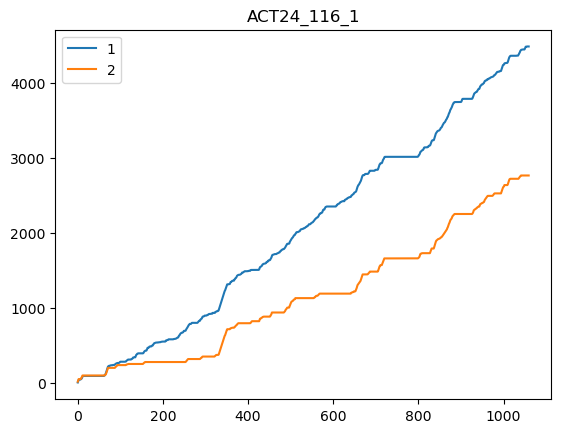

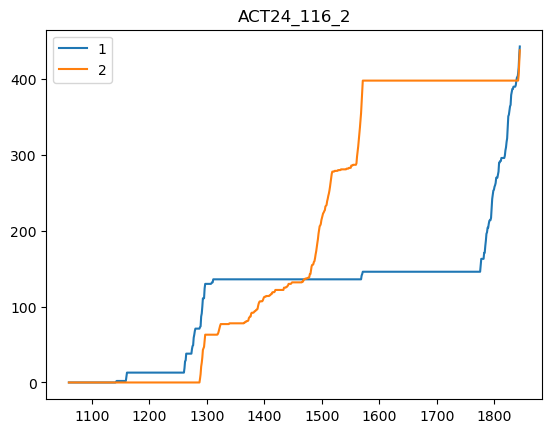

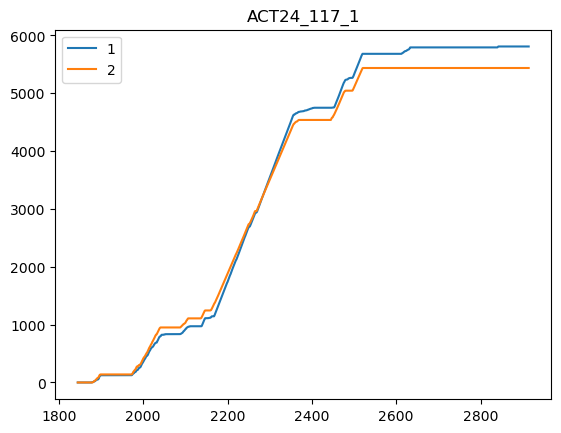

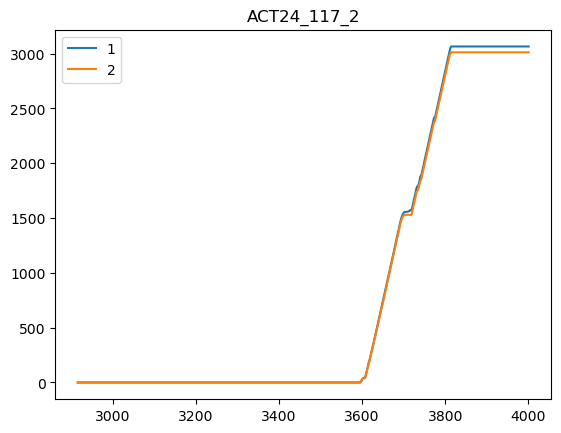

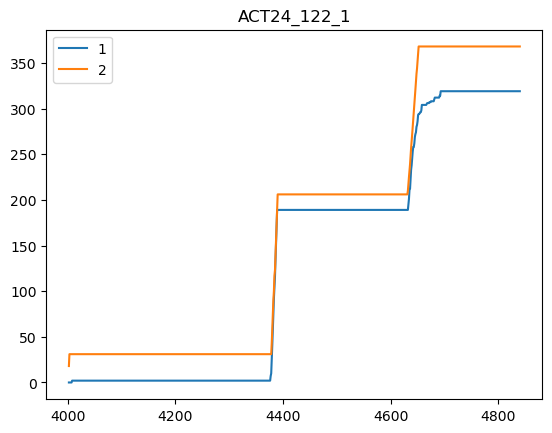

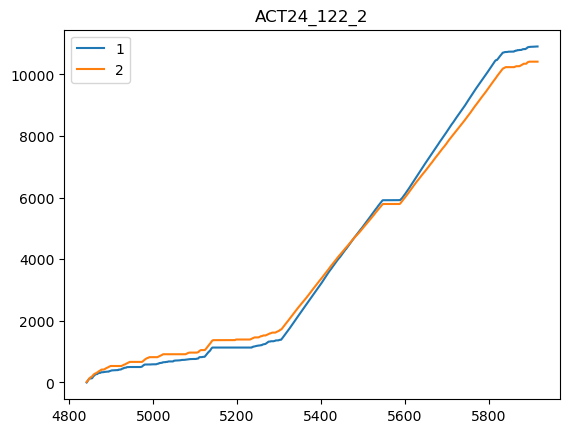

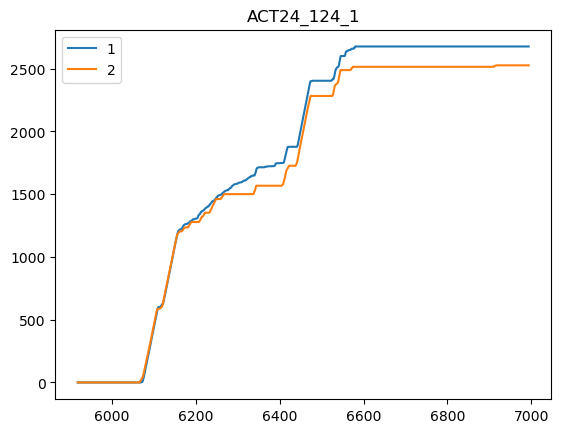

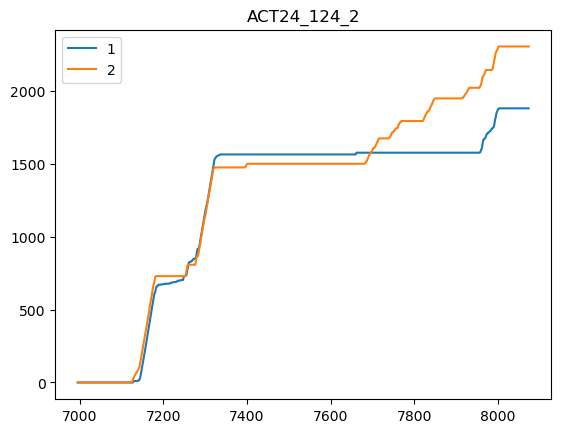

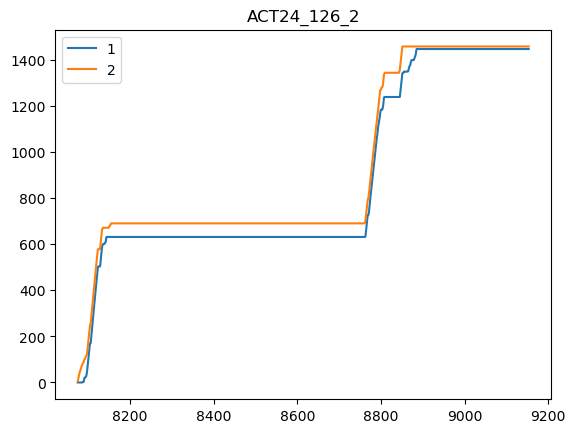

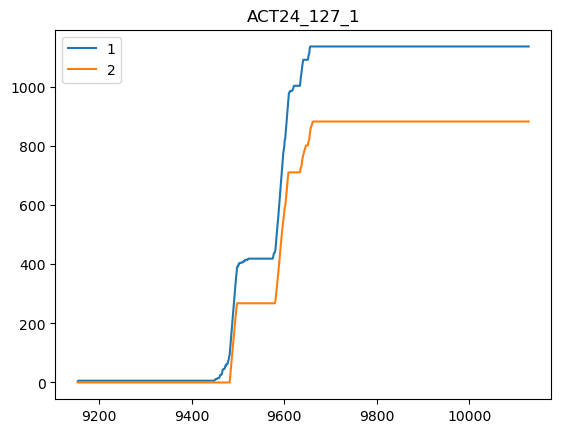

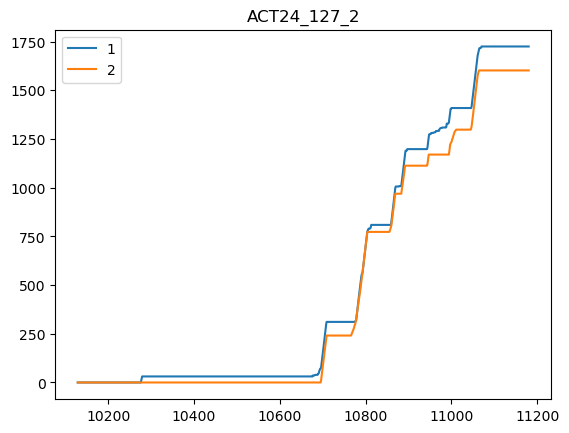

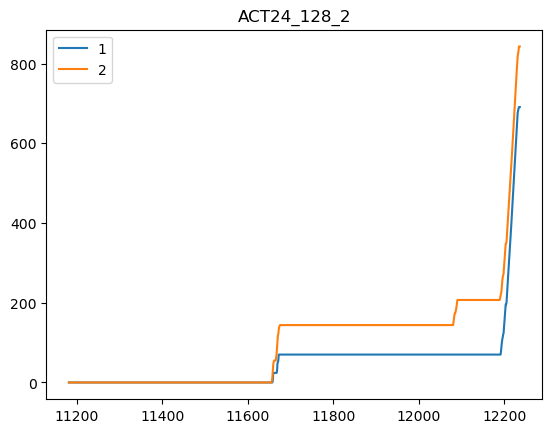

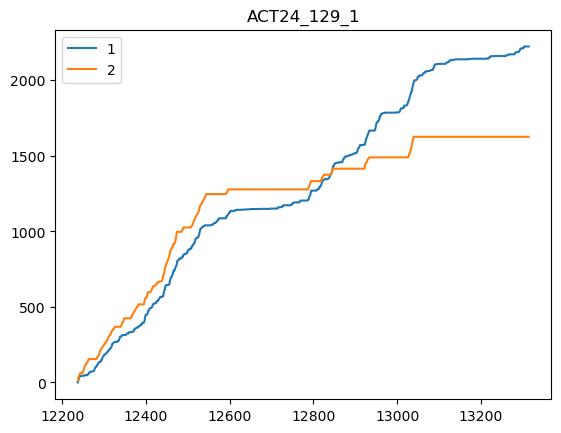

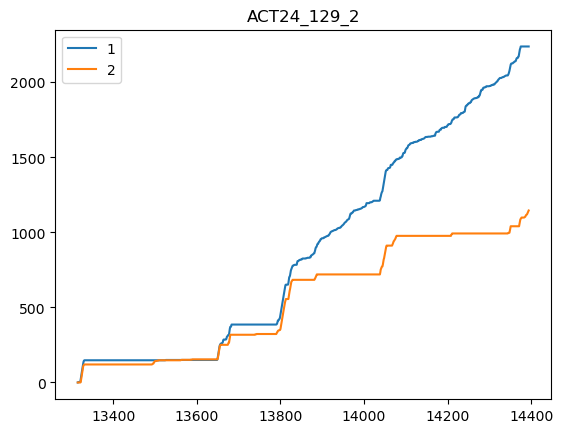

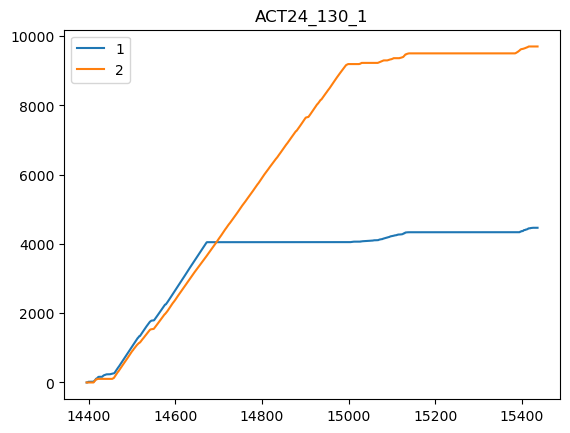

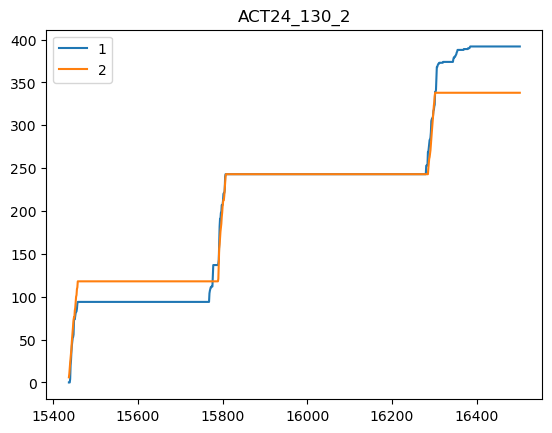

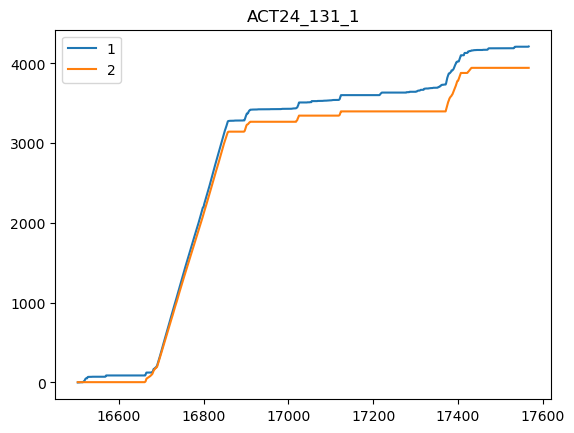

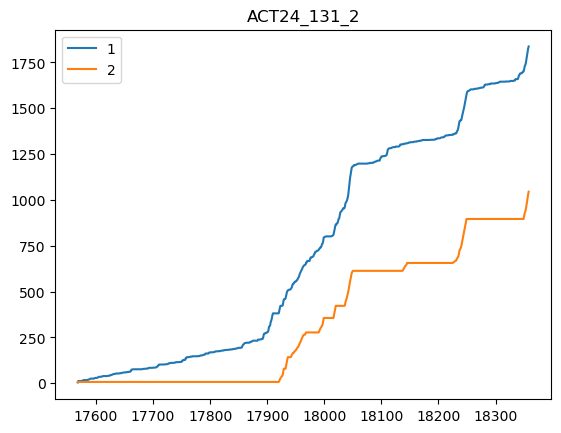

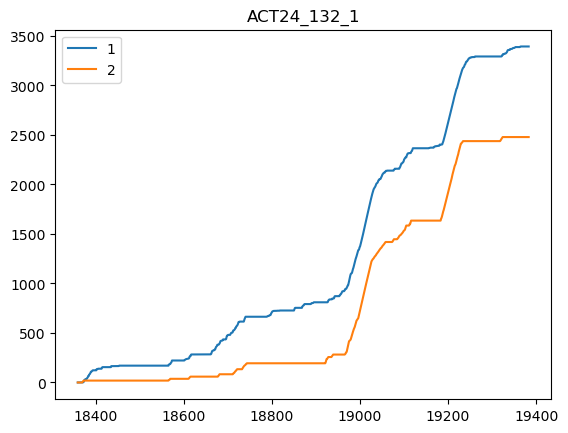

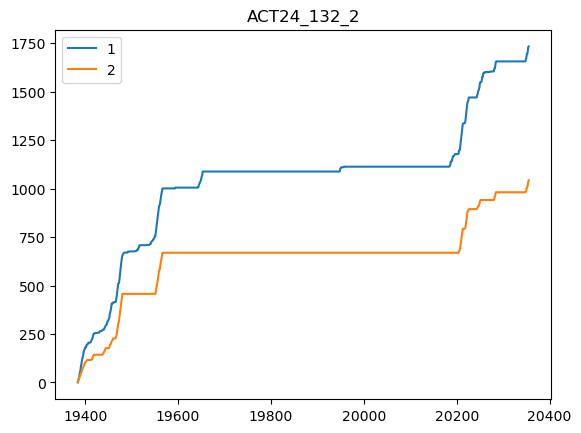

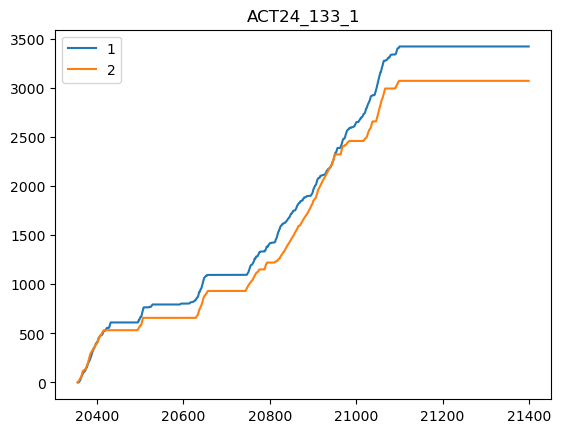

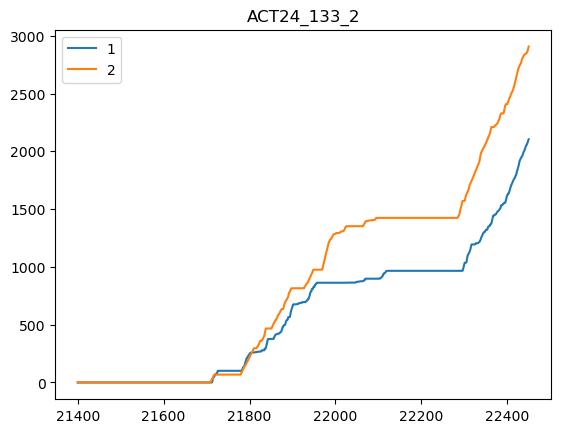

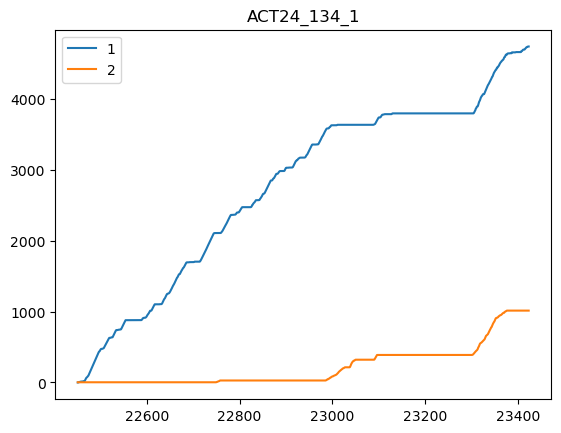

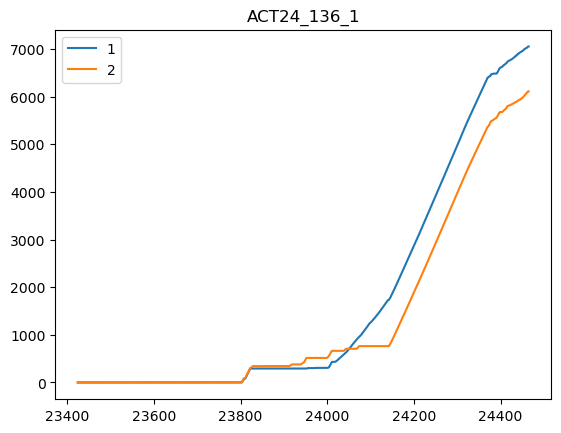

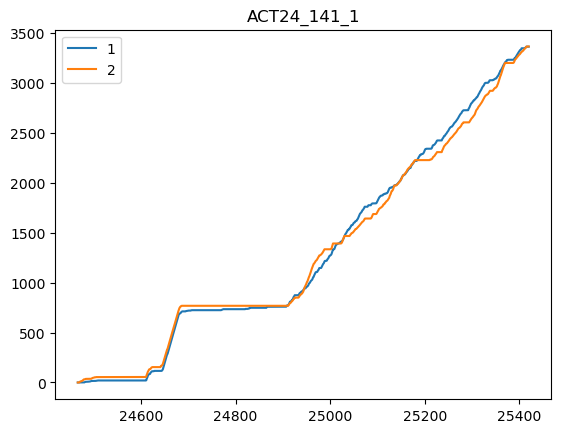

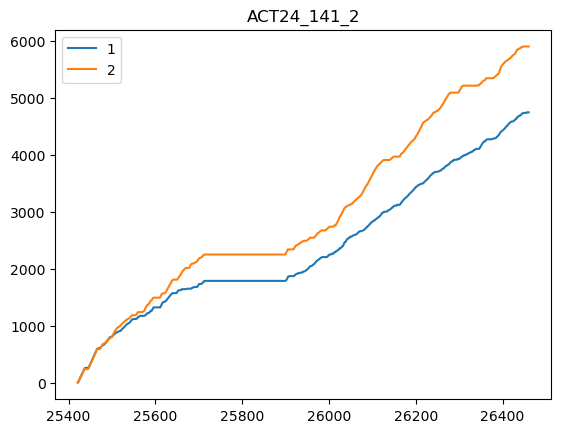

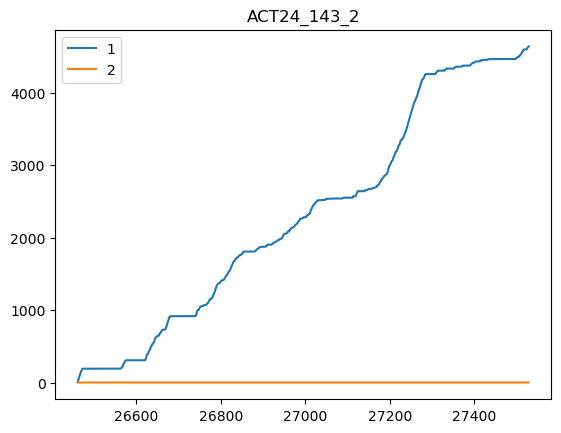

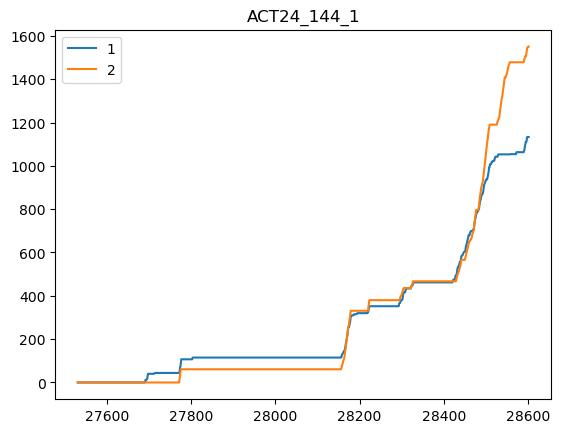

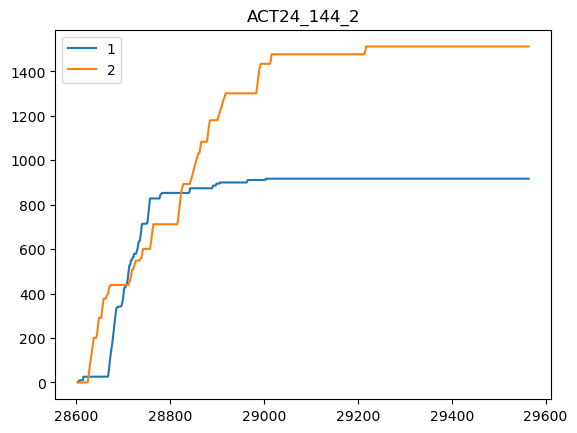

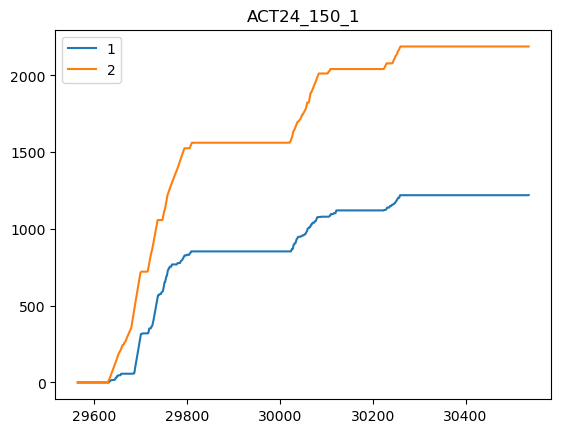

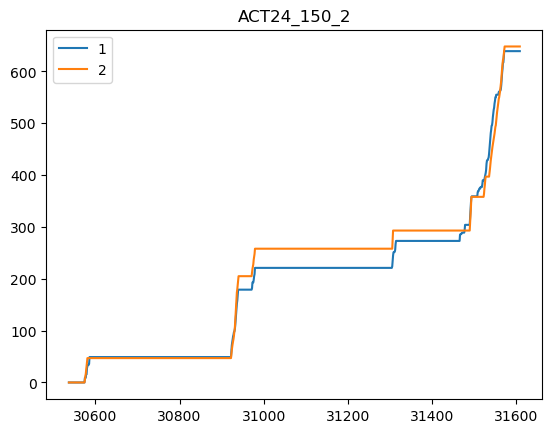

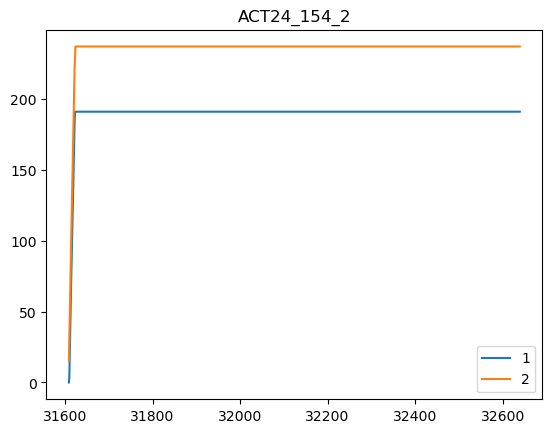

In [24]:
for g in np.unique(groups):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

Error between predicted and observed step counts, by posture:

In [25]:
Y_all = np.load(path + "Y_all.npy")
Y_all

array(['stand and move', 'walk', 'walk', ..., 'sitting', 'sitting',
       'sitting'], dtype='<U20')

In [27]:
pred = pd.concat([pd.Series(Y_all),
                  pd.Series(Y_step), steps_validation.reset_index(drop=True)], axis=1)
results = pred.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ascend stairs,1980,717,1263,0.637879
bike,0,271,-271,inf
descend stairs,855,812,43,0.050292
kneeling/ squatting,512,505,7,0.013672
lying,25,0,25,1.000000
muscle strengthening,37,50,-13,0.351351
other sport movement,81,0,81,1.000000
running,0,0,0,NaN
sitting,2738,3323,-585,0.213660


# Output predictions

Output predictions to .csv

In [28]:
pred_k = pd.concat([pd.Series(groups), pd.Series(T), steps_validation.reset_index(drop=True)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_k

,id_obs,time,pred_steps
0,ACT24_116_1,2019-08-20 08:09:05,18
1,ACT24_116_1,2019-08-20 08:09:15,17
2,ACT24_116_1,2019-08-20 08:09:25,17
3,ACT24_116_1,2019-08-20 08:09:35,0
4,ACT24_116_1,2019-08-20 08:09:45,0
...,...,...,...
32635,ACT24_154_2,2020-02-23 15:55:09,0
32636,ACT24_154_2,2020-02-23 15:55:19,0
32637,ACT24_154_2,2020-02-23 15:55:29,0
32638,ACT24_154_2,2020-02-23 15:55:39,0


In [29]:
pred_k.to_csv("predicted_keadle_goldilocks_loocv.csv")